# 🖌️ View as RGB images


In [ ]:
#| default_exp repr_rgb

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq
from lovely_numpy import lovely

In [ ]:
# |hide
# lt.monkey_patch()

In [ ]:
# |export
# |hide
from typing import Union 
import numpy as np
from PIL import Image
import lovely_numpy as lnp

from lovely_numpy.utils.tile2d import hypertile

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.

class RGBProxy():
    """Flexible `PIL.Image.Image` wrapper"""
    
    def __init__(self, t:np.ndarray):
        super().__init__()
        # assert t.ndim == 3, f"Expecting a 3-dim array, got {t.shape}={t.ndim}"
        self.t = t

    
    def __call__(self, denorm=None, cl: Union[int, bool]=True, 
                    gutter_px=3, frame_px=1, view_width=966):
        t = self.t

        # swap channels if it's not channe-last already
        if not cl:
            # Is there any easy way to .permute() without knowing the number of dims?
            t = np.swapaxes(np.swapaxes(t, -3, -1), -3, -2)
            
        n_ch = t.shape[-1]
        assert n_ch in (3, 4), f"Expecting 3 (RGB) or 4 (RGBA) channels, got {n_ch}" 
        if denorm:
            means = np.array(denorm[0])
            stds = np.array(denorm[1])
            t = t * stds + means

        if t.ndim > 3:
            t = hypertile(  t=t,
                            gutter_px=gutter_px,
                            frame_px=frame_px,
                            view_width=view_width)

        return Image.fromarray((t * 255).astype(np.uint8))
    
    def _repr_png_(self):
        return self.__call__()._repr_png_()


In [ ]:
# |export
def rgb(t: np.ndarray, # Tensor to display. [[...], C,H,W] or [[...], H,W,C]
            denorm=None, # Reverse per-channel normalizatoin
            cl: Union[int, bool]=True,    # Channel-last
            gutter_px = 3,  # If more than one tensor -> tile with this gutter width
            frame_px=1,  # If more than one tensor -> tile with this frame width
            view_width=966): # targer width of the image
    return RGBProxy(t)( denorm=denorm, cl=cl,
                        gutter_px=gutter_px,
                        frame_px=frame_px,
                        view_width=view_width)

In [ ]:
# |hide 
image = np.load("mysteryman.npy").transpose(1, 2, 0)

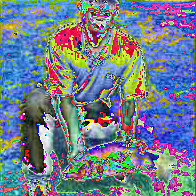

In [ ]:
rgb(image)

In [ ]:
two_images = np.stack([image]*2)
lovely(two_images)

ndarray[2, 196, 196, 3] f32 n=230496 x∈[-2.118, 2.640] μ=-0.388 σ=1.073

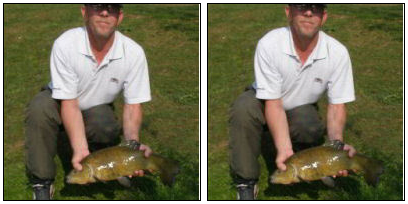

In [ ]:
in_stats = (    (0.485, 0.456, 0.406),  # Mean
                (0.229, 0.224, 0.225) ) # std
rgb(two_images, denorm=in_stats)

In [ ]:
# Make 8 images with progressively higher brightness and stack them 2x2x2.
eight_images = (np.stack([image]*8) + np.linspace(-2, 2, 8)[:,None,None,None])
eight_images = (eight_images
                     *np.array(in_stats[1])
                     +np.array(in_stats[0])
                ).clip(0,1).reshape(2,2,2,196,196,3)
                


lovely(eight_images)

ndarray[2, 2, 2, 196, 196, 3] n=921984 x∈[0., 1.000] μ=0.382 σ=0.319

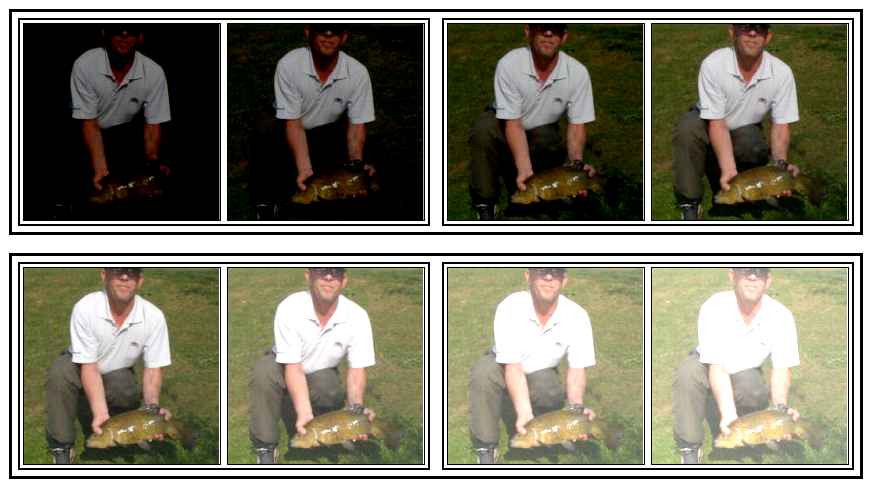

In [ ]:
rgb(eight_images)

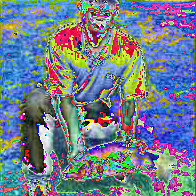

In [ ]:
# You can do channel-first too:
rgb(image.transpose(-1, 0, 1), cl=False)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()